**Final Project: Overdamped and Markovian Langevin Equation**

Frédéric Sonak

This markdown was created with the assistance of ChatGPT, focusing on grammar, spelling, and readability.

**Background**





Importing all libraries used in this code.

In [1]:
from cProfile import label

import matplotlib.pyplot as plt
from jedi.debug import increase_indent
from matplotlib import animation, rc
from IPython.display import HTML

from numba import njit

import copy
import numpy as np
import scipy as scy
from sympy import reduced
from sympy.physics.units import acceleration
from tqdm import tqdm
import time


**Task 1: Implement Markovian Langevin Equation**

To describe the dynamics by the Markovian Langevin equation the following integrator is implemented:

$
x(t + \Delta t) = x(t) + v(t) \Delta t
$

with the velocity given by

$
v(t + \Delta t) = v(t) - \frac{1}{m} \frac{dU (x(t))}{dx} \Delta t - \frac{1}{m} \Gamma v(t) \Delta t + \frac{1}{m} \sqrt{2k_B T \Gamma \Delta t R (t)}
$

In contrast to the excercise sheet, the potential is not constant but given as a double well:

$
U(x) = k_B T (0.28(0.25x^4 + 0.1x^3 - 3.24x^2) + 3.5)
$


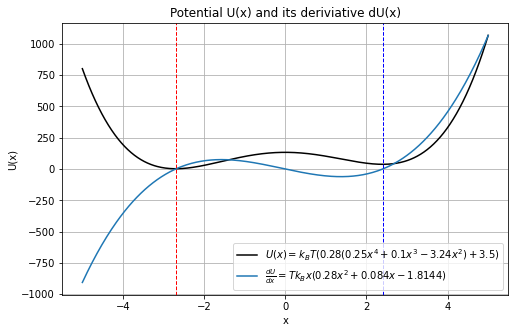

In [76]:
# quick visualisation of the potential:

# As later on k_B * T is set to 38 only one variable:
# k_B_x_T = k_B * T is introduced

# Define the potential function U(x)
def U(x, k_B_x_T):
    return k_B_x_T * (0.28 * (0.25 * x**4 + 0.1 * x**3 - 3.24 * x**2) + 3.5)

# Compute the derivative of U(x) (calculation done manually - CHECKED with WOLFRAMALPHA)
def dU_dx(x, k_B_x_T, prevent_overflow=True):
    dudx = k_B_x_T * x * (0.28 * x**2 + 0.084 * x - 1.8144)

    # Prevent overflow issues by limiting force values
    if prevent_overflow:
        dudx = np.clip(dudx, -1e5, 1e5)  # Adjust limits if necessary
    return dudx

# Define x range
x = np.linspace(-5, 5, 500)

# Compute U(x), dU_dx
U_values = U(x, 38)
dU_dx_values = dU_dx(x, 38)

# Minima locations (calculated manually)
minima_x1, minima_x2 = -2.7, 2.4

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, U_values, label=r"$U(x) = k_B T (0.28(0.25x^4 + 0.1x^3 - 3.24x^2) + 3.5)$", color="black")
plt.plot(x, dU_dx_values, label=r"$\frac{dU}{dx} = T k_B x (0.28 x^2 + 0.084 x - 1.8144)$")

# Vertical lines at minima
plt.axvline(minima_x1, color="red", linestyle="--", linewidth=1)
plt.axvline(minima_x2, color="blue", linestyle="--", linewidth=1)

plt.xlabel("x")
plt.ylabel("U(x)")
plt.title("Potential U(x) and its deriviative dU(x)")
plt.legend()
plt.grid(True)

plt.show()

Next the integrator is implemented (based on sheet 10).

In [51]:
# Langevin integrator function
def langevin_integrator(steps, dt, x0, v0, mass, gamma, k_B_x_T, verbose=False):
    """
    Langevin integrator including the force from dU/dx.

    Parameters:
    - steps: Number of time steps
    - dt: Time step size
    - x0: Initial position (array)
    - v0: Initial velocity (array)
    - mass: Mass of the particle
    - gamma: Damping coefficient
    - k_B_x_T: Bolzmann constant times temperature
    - verbose: for debugging purposes

    Returns:
    - positions: Array of particle positions over time
    - velocities: Array of particle velocities over time
    """

    # Start timer for measuring how long the code runs
    start_time = time.time()

    # Initialise position and velocity arrays
    positions = np.zeros((steps))
    velocities = np.zeros((steps))

    # Set initial position and velocity
    positions[0] = x0
    velocities[0] = v0

    # calculate constants outside of loop to remove redundant calculations
    # speeds up by about 20 % for large loops
    const_1 = gamma * dt / mass
    const_2 = np.sqrt(2  * k_B_x_T * gamma *  dt) / mass

    # Integration loop

    loop_range = range(steps - 1)

    for i in loop_range:
        # Generate Gaussian random number (zero mean, unit variance)
        R = np.random.normal(0, 1)  # Generate a single random number

        # Current velocity and position
        v = velocities[i]
        x = positions[i]

        # Update velocity using Langevin equation
        v_next = v + (-dU_dx(x, k_B_x_T) / mass) * dt - const_1 * v + const_2 * R

        # Update position
        x_next = x + v_next * dt

        # Store the updated values
        velocities[i + 1] = v_next
        positions[i + 1] = x_next

        # Debugging: Check if x, force, or noise is growing too fast
        if i % (steps // 10) == 0:  # Print 10 times throughout simulation
            print(f"Step {i}: x = {x_next:.5f}, v = {v_next:.5f}, force = {-dU_dx(x, k_B_x_T):.2f} noise = {R:.5f}")

    # End timer
    end_time = time.time()
    print(f"Time elapsed: {end_time - start_time:.2f} seconds")

    return positions, velocities

In [52]:
#run simulation with given parameters from task sheet

gamma = 100
k_B_x_T = 38          # Bolzmann consant times temperature # ps^-1
dt = 0.001            # Time step size # ps
steps = 5 * 10**6         # number of time steps
mass = 1                # mass in ps
x0 = 0                 # Initial position
v0 = 0                 # Initial velocity


# Run simulation
positions, velocities = langevin_integrator(steps, dt, x0, v0, mass, gamma, k_B_x_T, verbose=True)


Step 0: x = 0.00051, v = 0.51428, force = 0.00 noise = 0.18655
Step 500000: x = 1.05630, v = 0.71981, force = 56.71 noise = -0.79387
Step 1000000: x = -2.18568, v = -0.87722, force = -54.91 noise = 0.19890
Step 1500000: x = -1.59865, v = 14.82861, force = -74.86 noise = 0.60812
Step 2000000: x = -3.01417, v = 1.82504, force = 54.92 noise = 0.40321
Step 2500000: x = 1.94486, v = 10.81629, force = 44.43 noise = 1.26294
Step 3000000: x = -2.52741, v = 4.20517, force = -22.37 noise = 2.01531
Step 3500000: x = -2.72611, v = 6.62850, force = 4.89 noise = 0.35080
Step 4000000: x = -2.67399, v = -1.67142, force = -3.99 noise = 0.50494
Step 4500000: x = -1.58526, v = -8.49740, force = -74.94 noise = -0.15660
Time elapsed: 69.04 seconds


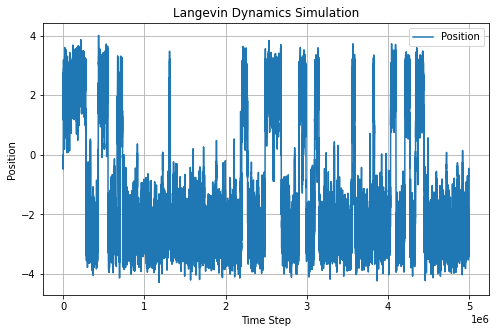

In [53]:
# === Plot the results ===
plt.figure(figsize=(8, 5))
plt.plot(np.arange(steps), positions.flatten(), label="Position")
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.title("Langevin Dynamics Simulation")
plt.legend()
plt.grid(True)
plt.show()

Next the particles need to be assigned the core states left, or right. For consistency the inital state (x = 0) is simply assigned "left".

In [54]:
def assign_core_states(positions):
    """
    Assigns each position in the trajectory to either the 'left' or 'right' state.
    Uses the last visited state for intermediate points (-1 < x < 1).
    """
    states = np.zeros(len(positions), dtype=int)  # 0 = left, 1 = right
    current_state = 0  # Assume starting in "left" (x(0) = 0)

    for i in range(len(positions)):
        x = positions[i]
        if x < -1:
            current_state = 0  # Left
        elif x > 1:
            current_state = 1  # Right
        # If -1 <= x <= 1, keep the last assigned state

        states[i] = current_state  # Store the state

    return states

In [55]:
states = assign_core_states(positions)

quick statistics and chekc if it makes sense

In [56]:
def quick_statistics_check(states, verbose=True):
    # Count occurrences of left (0) and right (1) states
    left_count = np.sum(states == 0)
    right_count = np.sum(states == 1)

    # Total simulations
    total_simulations = len(states)

    # Check if the sum is correct
    sum_check = left_count + right_count == total_simulations

    # Print results
    if verbose:
        print(f"Left states (0): {left_count} = {left_count/total_simulations*100}%")
        print(f"Right states (1): {right_count} = {right_count/total_simulations*100}%")
        print(f"Total states: {total_simulations}")
        print(f"Check if both add up correctly: {'Yes' if sum_check else 'No'}")

    return left_count, right_count, total_simulations, sum_check

left_count_langevin, right_count_langevin, _,_  = quick_statistics_check(states)


Left states (0): 3841719 = 76.83438%
Right states (1): 1158281 = 23.16562%
Total states: 5000000
Check if both add up correctly: Yes


Next, the transitions from left to right are counted. These numbers are called $\mathrm{N_{left\rightarrow right}}$ and $\mathrm{N_{right\rightarrow left}}$. The rate $\mathrm{k_{left\rightarrow right}}$ is given by:

$
\mathrm{k_{left\rightarrow right}} = \frac{\mathrm{N_{left\rightarrow right}}}{\mathrm{N_{left} \cdot \Delta t}}
$




In [103]:
def compute_transition_rates(states, left_count, right_count, verbose=True):
    # Count transitions from left (0) to right (1) and vice versa
    N_left_to_right = np.sum((states[:-1] == 0) & (states[1:] == 1))
    N_right_to_left = np.sum((states[:-1] == 1) & (states[1:] == 0))

    # Compute transition rates
    k_left_to_right = N_left_to_right / (left_count * dt)
    k_right_to_left = N_right_to_left / (right_count * dt)

    # Print results
    if verbose:
        print(f"Transition rate k(left -> right): {k_left_to_right:.5f} per ps")
        print(f"Transition rate k(right -> left): {k_right_to_left:.5f} per ps")

    return k_left_to_right, k_right_to_left

_,_ = compute_transition_rates(states, left_count_langevin, right_count_langevin, verbose=True)

Transition rate k(left -> right): 0.09371 per ps
Transition rate k(right -> left): 0.31081 per ps


Plotting an exemplary particle postition.

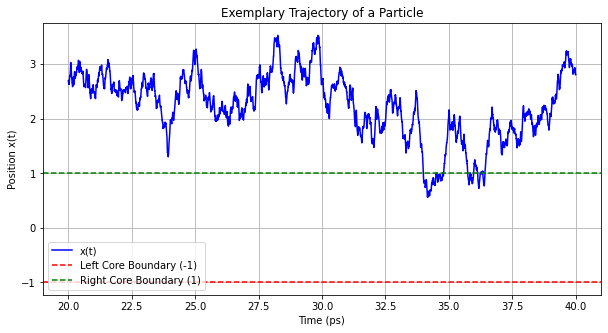

In [58]:
# Define example trajectory interval
# The interval is chosen from the above plot to show
# a relevant area of change of states

start_index = 20000
end_index = 40000

# Generate time array
time_array = np.arange(start_index, end_index) * dt

# Plot the trajectory
plt.figure(figsize=(10, 5))
plt.plot(time_array, positions[start_index:end_index], label="x(t)", color="blue")

# Mark core state boundaries
plt.axhline(-1, color="red", linestyle="--", label="Left Core Boundary (-1)")
plt.axhline(1, color="green", linestyle="--", label="Right Core Boundary (1)")

plt.xlabel("Time (ps)")
plt.ylabel("Position x(t)")
plt.title("Exemplary Trajectory of a Particle")
plt.legend()
plt.grid(True)
plt.show()

Next, Histogram of the trajectory:

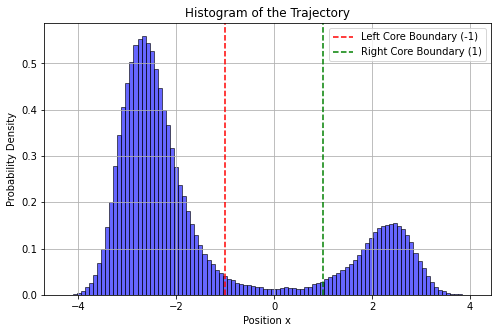

In [59]:
# Plot histogram of the trajectory
plt.figure(figsize=(8, 5))
plt.hist(positions, bins=100, density=True, color="blue", alpha=0.6, edgecolor="black")

# Mark core state boundaries
plt.axvline(-1, color="red", linestyle="--", label="Left Core Boundary (-1)")
plt.axvline(1, color="green", linestyle="--", label="Right Core Boundary (1)")


plt.xlabel("Position x")
plt.ylabel("Probability Density")
plt.title("Histogram of the Trajectory")
plt.legend()
plt.grid(True)
plt.show()

**Task 2: Implement overdamped Langevin equation**

Du to large friction, in some cases, the acceleration can be neglected i.e. $\frac{dv}{dx} \approx 0$. Thus, the integrator of the position changes to

$
x(t + \Delta t) = x(t) - \frac{1}{m} \frac{1}{\Gamma} \frac{dU(x(t))}{dx} \Delta t
+ \frac{1}{m} \sqrt{\frac{2k_B T \Delta t}{\Gamma}} R(t)
$

For this the above simulation is rerun with the same conditions to compare the results.

In [77]:
def overdamped_langevin_integrator(steps, dt, x0, mass, gamma, k_B_x_T, verbose=False):
    """
    Overdamped Langevin integrator (no velocity term).

    Parameters:
    - steps: Number of time steps
    - dt: Time step size
    - x0: Initial position
    - mass: Mass of the particle
    - gamma: Friction coefficient
    - k_B_x_T: Boltzmann constant times temperature
    - verbose: If True, show progress with tqdm

    Returns:
    - positions: Array of particle positions over time
    """

    # Start timer for performance measurement
    start_time = time.time()

    # Initialize position array
    positions = np.zeros(steps)

    # Set initial position
    positions[0] = x0

    # Precompute constants
    const_1 = dt / (mass * gamma)
    const_2 = np.sqrt((2 * k_B_x_T * dt) / (mass * gamma))

    # Integration loop
    loop_range = range(steps - 1)

    for i in loop_range:
        # Generate Gaussian random number (zero mean, unit variance)
        R = np.random.normal(0, 1)

        # Current position
        x = positions[i]

        # Compute the force term: - dU/dx
        force = -dU_dx(x, k_B_x_T, prevent_overflow=True)

        const_1 = dt / (mass * gamma)

        const_2 = np.sqrt((2 * k_B_x_T * dt) / (gamma))/ mass

        # Update position using the overdamped Langevin equation
        x_next = x + (-const_1 * force + const_2 * R)

        # Prevent numerical issues (clamping x to avoid divergence)
        # I had this issue earlier, so values are clipped to the range from the
        # visualisation of the potential from earlier
        # x_next = np.clip(x_next, -5, 5)  # Adjust limits if needed

        # Store updated position
        positions[i + 1] = x_next

        # Debugging: Check if x, force, or noise is growing too fast
        if i % (steps // 10) == 0:  # Print 10 times throughout simulation
            print(f"Step {i}: x = {x_next:.5f}, force = {-dU_dx(x, k_B_x_T):.2f} noise = {R:.5f}")

    # End timer
    end_time = time.time()
    print(f"Time elapsed: {end_time - start_time:.2f} seconds")

    return positions

The force seems to explode. So to check this I will rerun the simulation but with a smaller step size.

still force gets too big. Lets try increasing the damping gamma.

multiple things are done to ensure stability of the integrator.

Step 0: x = -0.00124, force = 0.00, noise = -0.34871
Step 100000: x = 0.26013, force = 17.58, noise = -0.21091
Step 200000: x = -0.04651, force = -3.07, noise = -0.56050
Step 300000: x = 0.00750, force = 1.01, noise = -2.01207
Step 400000: x = 0.72995, force = 44.84, noise = -2.10690
Step 500000: x = 0.02300, force = 1.57, noise = 0.03835
Step 600000: x = -0.49737, force = -33.96, noise = 0.83899
Step 700000: x = -0.88997, force = -56.51, noise = 0.69895
Step 800000: x = -0.89337, force = -56.77, noise = 1.19378
Step 900000: x = 0.95825, force = 53.89, noise = -0.99046
Time elapsed: 23.57 seconds


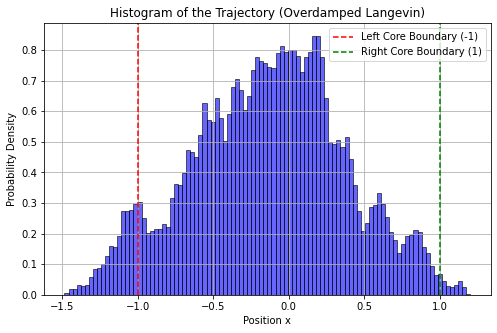

In [94]:
'''
to make it stable multiple things are implemented:
1. step size dt is decrease
2. gamma is increased
3. dUdx is clipped to prevent excessive acceleration
'''


# Compute the derivative of U(x) (force) with overflow prevention
def dU_dx(x, k_B_x_T):
    dudx = k_B_x_T * x * (0.28 * x ** 2 + 0.084 * x - 1.8144)
    return np.clip(dudx, -5000, 5000)  # Limit force to prevent instability


def overdamped_langevin_integrator(steps, dt, x0, mass, gamma, k_B_x_T, verbose=False):
    # no velocity

    start_time = time.time()

    positions = np.zeros(steps)
    positions[0] = x0

    const_1 = dt / (mass * gamma)
    const_2 = np.sqrt((2 * k_B_x_T * dt) / ( mass * gamma))

    for i in range(steps - 1):
        R = np.random.normal(0, 1)
        x = positions[i]
        force = -dU_dx(x, k_B_x_T)

        x_next = x + (-const_1 * force + const_2 * R)

        # Clip to prevent divergence
        x_next = np.clip(x_next, -5, 5)

        positions[i + 1] = x_next

        if verbose and i % (steps // 10) == 0:
            print(f"Step {i}: x = {x_next:.5f}, force = {force:.2f}, noise = {R:.5f}")

    print(f"Time elapsed: {time.time() - start_time:.2f} seconds")
    return positions


# Run Simulations with Fixed Parameters

gamma = 300  # Increased damping
k_B_x_T = 38  # Boltzmann constant times temperature
dt = 0.00005  # Smaller step size for stability
steps = 1000000  # Reduced number of steps for speed
mass = 1  # Particle mass
x0 = 0  # Initial position

# Run Overdamped Langevin Simulation
positions_overdamped = overdamped_langevin_integrator(steps, dt, x0, mass, gamma, k_B_x_T, verbose=True)

#Histogram of the Trajectory
plt.figure(figsize=(8, 5))
plt.hist(positions_overdamped, bins=100, density=True, color="blue", alpha=0.6, edgecolor="black")

# Mark core state boundaries
plt.axvline(-1, color="red", linestyle="--", label="Left Core Boundary (-1)")
plt.axvline(1, color="green", linestyle="--", label="Right Core Boundary (1)")

plt.xlabel("Position x")
plt.ylabel("Probability Density")
plt.title("Histogram of the Trajectory (Overdamped Langevin)")
plt.legend()
plt.grid(True)
plt.show()

Next calculate the transition rates.

In [95]:

states_overdamped = assign_core_states(positions_overdamped)

left_count_overdamped, right_count_overdamped, _, _ = quick_statistics_check(states_overdamped, verbose=True)


Left states (0): 639632 = 63.9632%
Right states (1): 360368 = 36.0368%
Total states: 1000000
Check if both add up correctly: Yes


Transition rates:

In [96]:
# Count transitions for overdamped Langevin case

compute_transition_rates(states_overdamped, left_count_overdamped, right_count_overdamped, verbose=True)


Transition rate k(left -> right): 0.06254 per ps
Transition rate k(right -> left): 0.05550 per ps


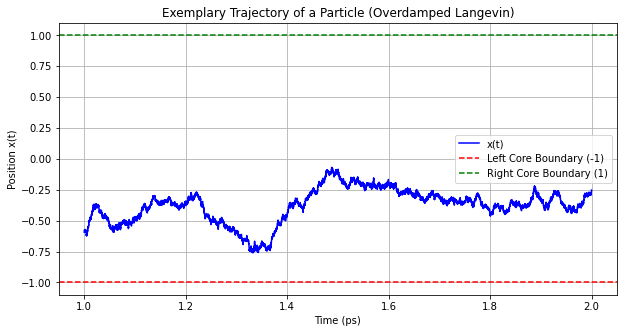

In [97]:
# Define example trajectory interval
start_index = 20000
end_index = 40000

# Generate time array
time_array = np.arange(start_index, end_index) * dt

# Plot the trajectory
plt.figure(figsize=(10, 5))
plt.plot(time_array, positions_overdamped[start_index:end_index], label="x(t)", color="blue")

# Mark core state boundaries
plt.axhline(-1, color="red", linestyle="--", label="Left Core Boundary (-1)")
plt.axhline(1, color="green", linestyle="--", label="Right Core Boundary (1)")

plt.xlabel("Time (ps)")
plt.ylabel("Position x(t)")
plt.title("Exemplary Trajectory of a Particle (Overdamped Langevin)")
plt.legend()
plt.grid(True)
plt.show()

Histogram:

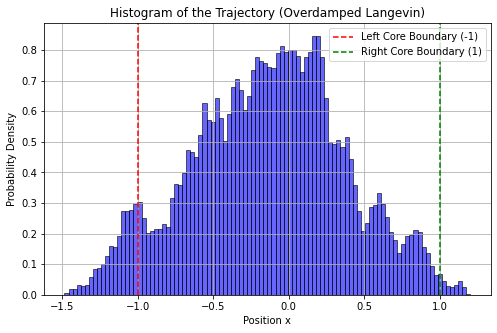

In [98]:
# Plot histogram of the trajectory for overdamped case
plt.figure(figsize=(8, 5))
plt.hist(positions_overdamped, bins=100, density=True, color="blue", alpha=0.6, edgecolor="black")

# Mark core state boundaries
plt.axvline(-1, color="red", linestyle="--", label="Left Core Boundary (-1)")
plt.axvline(1, color="green", linestyle="--", label="Right Core Boundary (1)")

plt.xlabel("Position x")
plt.ylabel("Probability Density")
plt.title("Histogram of the Trajectory (Overdamped Langevin)")
plt.legend()
plt.grid(True)
plt.show()

In [99]:
# Check if there are NaN or Inf values in positions_overdamped
num_nans = np.sum(np.isnan(positions_overdamped))
num_infs = np.sum(np.isinf(positions_overdamped))

print(f"NaN values in positions_overdamped: {num_nans}")
print(f"Inf values in positions_overdamped: {num_infs}")


NaN values in positions_overdamped: 0
Inf values in positions_overdamped: 0


**Task 3: Compare Langevin Equations**

In the last step both Langevin equations will be run for different friction coefficients $\Gamma$ ranging from 75 down to 10.

The calculated transition rates $k_{i \rightarrow j}$ will be compared with the theoretical formula

$
k_{i \to j}(\Gamma) \approx \frac{\omega_i \omega_{\text{max}}}{2 \pi \Gamma} e^{-\frac{U(x_{\text{max}}) - U(x_i)}{k_B T}}
$

with $\omega_i^2 = \frac{d^2 U (x_i)}{dx^2}$ and $\omega_\mathrm{max}^2 = - \frac{d^2 U (x_\mathrm{max}) - U (x_i)}{dx^2}$.


In [100]:
# theoretical transition rate
def theoretical_transition_rate(gamma, omega_i, omega_max, U_max, U_min, k_B_x_T):
    """
    Computes the theoretical transition rate using Kramers' rate formula.

    Parameters:
    - gamma: Friction coefficient
    - omega_i: Curvature at the local minimum (well)
    - omega_max: Curvature at the local maximum (barrier)
    - U_max: Potential energy at the barrier
    - U_min: Potential energy at the minimum
    - k_B_x_T: Boltzmann constant times temperature

    Returns:
    - Theoretical transition rate k(i -> j)
    """
    return (omega_i * omega_max) / (2 * np.pi * gamma) * np.exp(-(U_max - U_min) / k_B_x_T)

Next run langevin for different gammas:

In [104]:
# Define range of gamma values to test
gamma_values = np.array([75, 50, 25, 15, 10])  # Different damping values

# Store transition rates
k_left_to_right_markovian = []
k_right_to_left_markovian = []
k_left_to_right_overdamped = []
k_right_to_left_overdamped = []

for gamma in gamma_values:
    print(f"\nRunning simulations for gamma = {gamma}")

    # Run Task 1 (Markovian Langevin)
    positions_markovian, velocities_markovian = langevin_integrator(steps, dt, x0, v0, mass, gamma, k_B_x_T, verbose=False)
    states_markovian = assign_core_states(positions_markovian)
    left_count_m, right_count_m, _, _ = quick_statistics_check(states_markovian, verbose=False)
    k_m_left, k_m_right = compute_transition_rates(states_markovian, left_count_m, right_count_m, verbose=False)

    k_left_to_right_markovian.append(k_m_left)
    k_right_to_left_markovian.append(k_m_right)

    # Run Task 2 (Overdamped Langevin)
    positions_overdamped = overdamped_langevin_integrator(steps, dt, x0, mass, gamma, k_B_x_T, verbose=False)
    states_overdamped = assign_core_states(positions_overdamped)
    left_count_o, right_count_o, _, _ = quick_statistics_check(states_overdamped, verbose=False)
    k_o_left, k_o_right = compute_transition_rates(states_overdamped, left_count_o, right_count_o, verbose=False)

    k_left_to_right_overdamped.append(k_o_left)
    k_right_to_left_overdamped.append(k_o_right)


Running simulations for gamma = 75
Time elapsed: 14.84 seconds


<ipython-input-103-6e018775b33c>:8: RuntimeWarning: invalid value encountered in true_divide
  k_right_to_left = N_right_to_left / (right_count * dt)


Time elapsed: 23.73 seconds

Running simulations for gamma = 50
Time elapsed: 14.69 seconds
Time elapsed: 24.64 seconds

Running simulations for gamma = 25
Time elapsed: 14.83 seconds
Time elapsed: 23.65 seconds

Running simulations for gamma = 15
Time elapsed: 14.77 seconds
Time elapsed: 23.62 seconds

Running simulations for gamma = 10
Time elapsed: 14.66 seconds
Time elapsed: 24.16 seconds


now calculate theoretical transition rates for each gamma.

In [105]:
# Parameters for theoretical calculation
omega_i = 1.0  # Assumed well curvature (needs to be determined)
omega_max = 1.5  # Assumed barrier curvature
U_max = U(0, k_B_x_T)  # Potential at barrier (x=0)
U_min = U(-2.7, k_B_x_T)  # Potential at left well (x=-2.7)

# Compute theoretical rates for each gamma
theoretical_rates = []
for gamma in gamma_values:
    k_theory = theoretical_transition_rate(gamma, omega_i, omega_max, U_max, U_min, k_B_x_T)
    theoretical_rates.append(k_theory)